
Closest to Critical Point:


/var/folders/g6/xn7nvvtn4ng5pf9bhxfs7p2m0000gn/T/ipykernel_43327/3984782127.py:96: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  critical_points = fsolve(first_derivative, x_smooth.mean())


,mask,opacity,density,adv_acc,quality,distance_to_critical
29,diamond,128,100,0.7,0.383946,0.074752
25,diamond,128,1,0.7,0.383946,0.074752
26,diamond,128,25,0.7,0.383946,0.074752
27,diamond,128,50,0.7,0.383946,0.074752
28,diamond,128,75,0.7,0.383946,0.074752
93,word,192,75,0.7,0.361565,0.097133
94,word,192,100,0.8,0.363701,0.114688
91,word,192,25,0.8,0.356766,0.121623
0,circle,64,1,0.8,0.546790,0.188092
4,circle,64,100,0.8,0.546790,0.188092


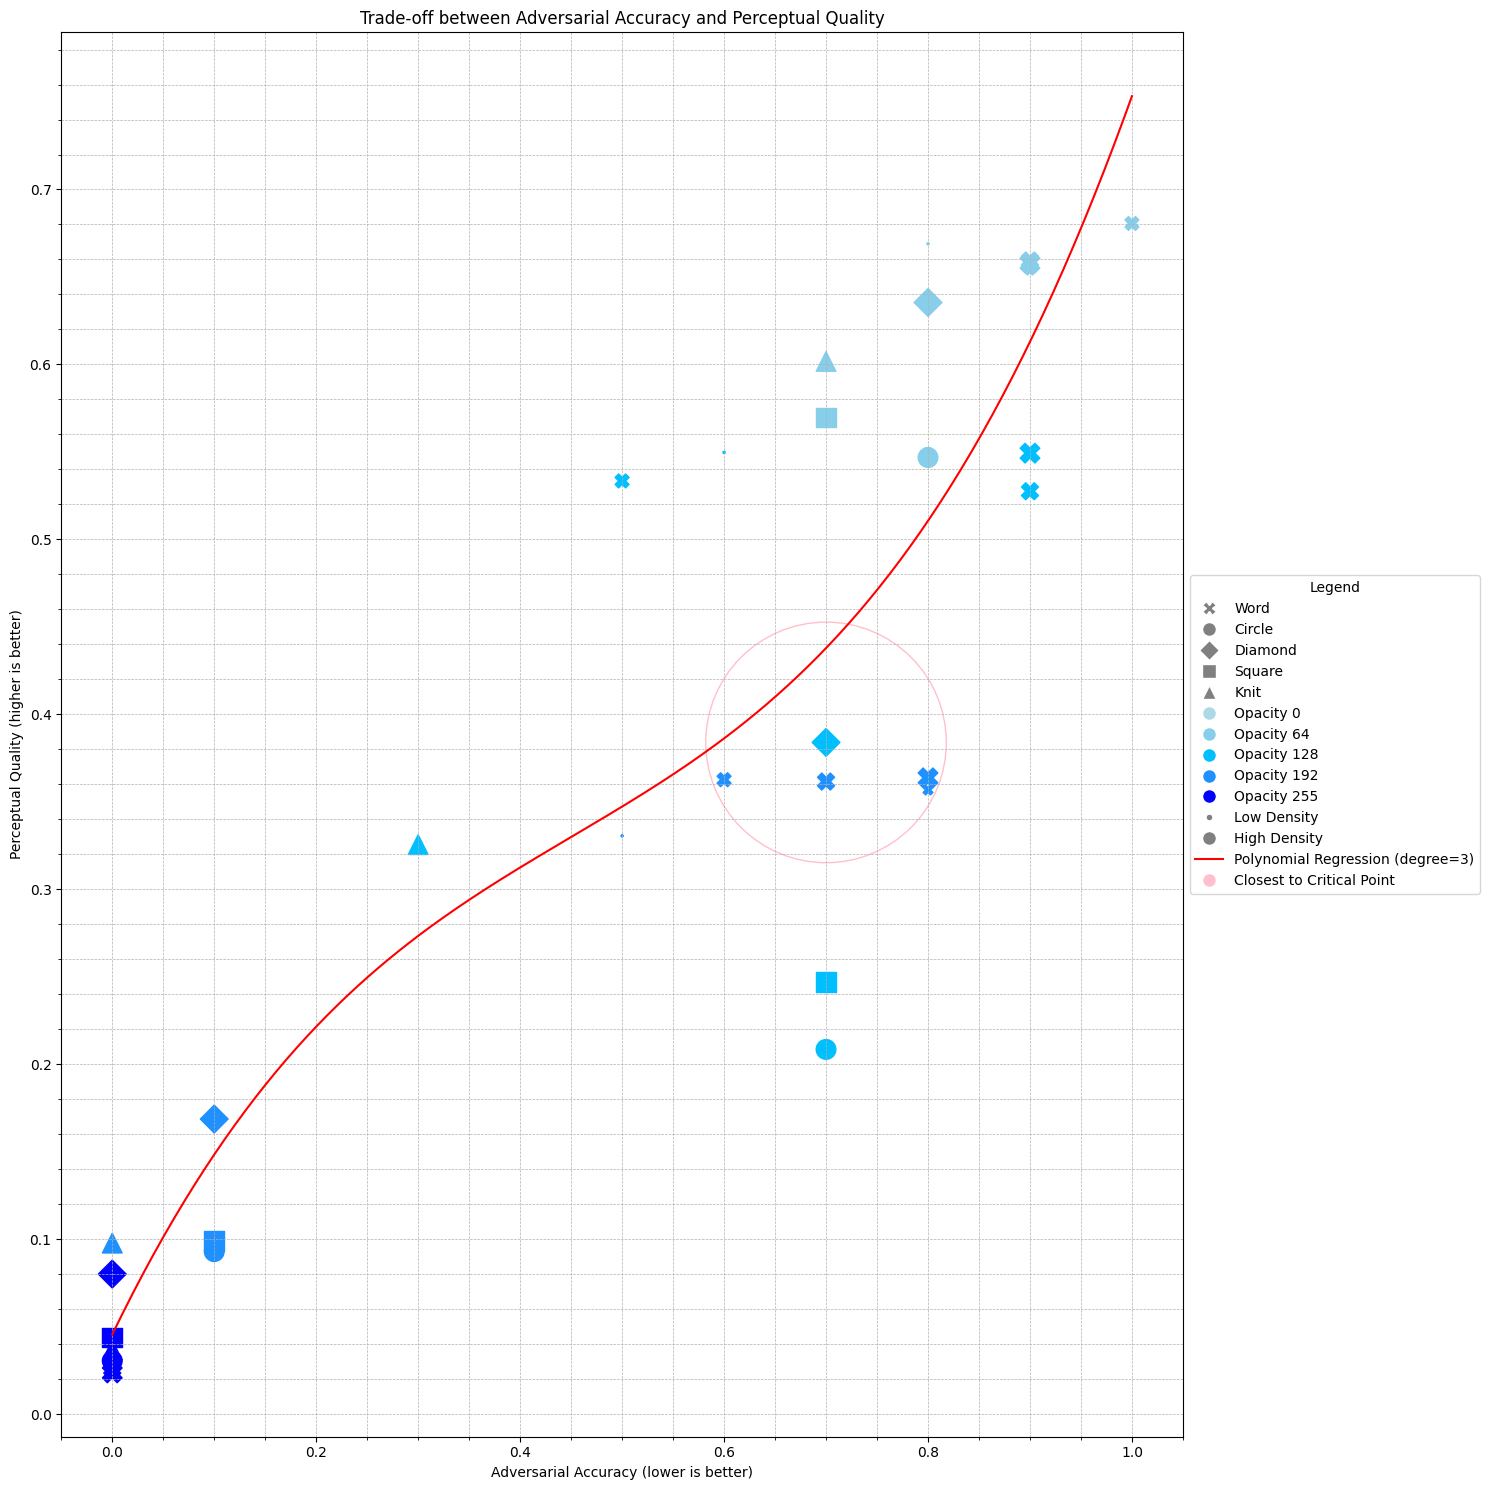

In [51]:
from scipy.optimize import minimize_scalar
from scipy.optimize import fsolve
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


datapath = Path.cwd().parent / "data" / "eval" / "0-eval_cls_mask.csv"
data = pd.read_csv(datapath)

"""
preprocessing
"""

data = data.replace([np.inf, -np.inf], np.nan).dropna()

# add 2 inferred metrics
data['adv_acc'] = (data['advx_acc1'] + data['advx_acc5']) / 2
data['quality'] = (data['cosine_sim'] + data['psnr'] / 100 + data['ssim']) / 3

# group by mask, opacity, and density - get mean of just the 2 inferred metrics
data = data.groupby(['mask', 'opacity', 'density']).agg({
    'adv_acc': 'mean',
    'quality': 'mean',
}).reset_index()

data = data.replace([np.inf, -np.inf], np.nan).dropna()
if np.isinf(data['adv_acc']).any() or np.isinf(data['quality']).any():
    print("\nwarning: Infinity values still present in the data")

"""
scatter plot
"""

markers = {'word': 'X', 'circle': 'o', 'diamond': 'D', 'square': 's', 'knit': '^'}
colors = {0: 'lightblue', 64: 'skyblue', 128: 'deepskyblue', 192: 'dodgerblue', 255: 'blue'}

plt.figure(figsize=(15, 15))

for mask in markers:
    for opacity in colors:
        mask_opacity_data = data[(data['mask'] == mask) & (data['opacity'] == opacity)]
        plt.scatter(mask_opacity_data['adv_acc'], mask_opacity_data['quality'], 
                    marker=markers[mask], c=colors[opacity], s=mask_opacity_data['density']*2,
                    label=f'{mask}, opacity={opacity}')

"""
polynomial regression
"""

x = data['adv_acc'].values.reshape(-1, 1)
y = data['quality'].values

degree = 3
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(x, y)

x_smooth = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
y_smooth = polyreg.predict(x_smooth)

plt.plot(x_smooth, y_smooth, color='red', label=f'Polynomial Regression (degree={degree})')

"""
critical point
"""

# calculate first and second derivatives
poly_coef = polyreg.named_steps['linearregression'].coef_
poly_coef = poly_coef[::-1]  # reverse the order of coefficients

def poly_func(x):
    return np.polyval(poly_coef, x)

def first_derivative(x):
    der_coef = np.polyder(poly_coef)
    return np.polyval(der_coef, x)

def second_derivative(x):
    der_coef = np.polyder(poly_coef, m=2)
    return np.polyval(der_coef, x)

# find critical points numerically
# = further improvements in adversarial accuracy come at a much steeper cost to perceptual quality, or vice versa.
critical_points = fsolve(first_derivative, x_smooth.mean())

def curvature(x):
    return np.abs(second_derivative(x)) / (1 + first_derivative(x)**2)**1.5

# find point of maximum curvature numerically
result = minimize_scalar(lambda x: -curvature(x), bounds=(x_smooth.min(), x_smooth.max()), method='bounded')
critical_x = result.x
critical_y = poly_func(critical_x)

# find the mask, opacity, and density that is closest to the critical point
data['distance_to_critical'] = np.abs(data['adv_acc'] - critical_x) + np.abs(data['quality'] - critical_y)
closest = data.loc[data['distance_to_critical'].idxmin()]
plt.scatter(closest['adv_acc'], closest['quality'], marker='o', facecolors='none', edgecolors='pink', s=30_000)

# sort by critical point distance and print the closest
print("\nClosest to Critical Point:")
closest = data.sort_values(by='distance_to_critical')
display(HTML(closest.head(10).to_html()))

"""
plot
"""

plt.xlabel('Adversarial Accuracy (lower is better)')
plt.ylabel('Perceptual Quality (higher is better)')
plt.title('Trade-off between Adversarial Accuracy and Perceptual Quality')

# legend for markers
legend_elements = [plt.Line2D([0], [0], marker='X', color='w', label='Word', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='D', color='w', label='Diamond', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='s', color='w', label='Square', markerfacecolor='gray', markersize=10),
                   plt.Line2D([0], [0], marker='^', color='w', label='Knit', markerfacecolor='gray', markersize=10)]

# legend for opacity
for opacity, color in colors.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f'Opacity {opacity}', markerfacecolor=color, markersize=10))

# legend for density
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Low Density', markerfacecolor='gray', markersize=5))
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='High Density', markerfacecolor='gray', markersize=10))

# legend for polynomial regression
legend_elements.append(plt.Line2D([0], [0], color='red', label=f'Polynomial Regression (degree={degree})'))

# legend for critical point
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Closest to Critical Point', markerfacecolor='pink', markersize=10))

plt.legend(handles=legend_elements, title='Legend', loc='center left', bbox_to_anchor=(1, 0.5))

# add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())

plt.tight_layout()
plt.show()